In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time  # Import time module to track epoch duration

In [2]:
# Kiểm tra GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Đường dẫn thư mục
data_dir = 'CNN_MultiClass_data'

In [4]:
# Phép biến đổi hình ảnh
transform = transforms.Compose([
    transforms.Resize((299, 299)),  # Resize ảnh về kích thước 299x299
    transforms.ToTensor(),  # Chuyển ảnh về dạng tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Chuẩn hóa ảnh theo mean và std của ImageNet
])

In [5]:
# Tạo dataset và dataloader
train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'animals'), transform=transform)
val_dataset = datasets.ImageFolder(os.path.join(data_dir, 'validation'), transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [6]:
# Tạo mô hình Inception-v3 pre-trained
def gen_model():
    weights = models.Inception_V3_Weights.DEFAULT
    model = models.inception_v3(weights=weights)

    # Đóng băng các lớp pre-trained
    for param in model.parameters():
        param.requires_grad = False

    # Thay đổi lớp Fully Connected để phù hợp với số lớp đầu ra (3 lớp)
    num_features = model.fc.in_features

    # Thay thế lớp Fully Connected cuối cùng bằng một mạng Sequential mới
    model.fc = nn.Sequential(
        nn.Linear(num_features, 512),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(512, 3)  # Số lớp đầu ra tương ứng với 3 lớp
    )

    # Nếu sử dụng aux_logits, cần thay đổi output lớp auxiliary
    if model.aux_logits:
        model.AuxLogits.fc = nn.Sequential(
            nn.Linear(model.AuxLogits.fc.in_features, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 3)
        )

    return model

In [7]:
model = gen_model().to(device)

In [8]:
# In kiến trúc của mô hình để kiểm tra
print('Model architecture')
print(model)

Model architecture
Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kerne

In [9]:
# Huấn luyện mô hình
def train_test_inception(model, train_loader, val_loader, epochs=10):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

    train_loss_history, val_loss_history = [], []
    train_acc_history, val_acc_history = [], []

    for epoch in range(epochs):
        start_time = time.time()  # Start timer for the epoch

        model.train()
        train_loss, train_corrects = 0.0, 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            # Nếu aux_logits được kích hoạt, chỉ tính loss với đầu ra chính
            if model.training and model.aux_logits:
                outputs = outputs.logits
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            train_corrects += torch.sum(preds == labels.data)

        train_loss = train_loss / len(train_loader.dataset)
        train_acc = train_corrects.double() / len(train_loader.dataset)

        model.eval()
        val_loss, val_corrects = 0.0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                if model.training and model.aux_logits:
                    outputs = outputs.logits
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                val_corrects += torch.sum(preds == labels.data)

        val_loss = val_loss / len(val_loader.dataset)
        val_acc = val_corrects.double() / len(val_loader.dataset)

        train_loss_history.append(train_loss)
        train_acc_history.append(train_acc.item())
        val_loss_history.append(val_loss)
        val_acc_history.append(val_acc.item())

        # Calculate and print the time taken for this epoch
        end_time = time.time()  # End timer for the epoch
        epoch_time = end_time - start_time  # Calculate elapsed time for the epoch

        print(f"Epoch {epoch + 1}/{epochs} | "
              f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f} | "
              f"Epoch Time: {epoch_time:.2f} seconds")  # Print epoch time

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(train_acc_history, label='Training Accuracy')
    plt.plot(val_acc_history, label='Validation Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(train_loss_history, label='Training Loss')
    plt.plot(val_loss_history, label='Validation Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()

Epoch 1/10 | Train Loss: 0.2508 Acc: 0.9047 | Val Loss: 0.1748 Acc: 0.9347 | Epoch Time: 49.28 seconds
Epoch 2/10 | Train Loss: 0.1518 Acc: 0.9473 | Val Loss: 0.0413 Acc: 0.9873 | Epoch Time: 49.38 seconds
Epoch 3/10 | Train Loss: 0.1058 Acc: 0.9610 | Val Loss: 0.0329 Acc: 0.9883 | Epoch Time: 49.59 seconds
Epoch 4/10 | Train Loss: 0.1229 Acc: 0.9573 | Val Loss: 0.0530 Acc: 0.9823 | Epoch Time: 49.27 seconds
Epoch 5/10 | Train Loss: 0.1201 Acc: 0.9587 | Val Loss: 0.0263 Acc: 0.9917 | Epoch Time: 49.84 seconds
Epoch 6/10 | Train Loss: 0.0782 Acc: 0.9720 | Val Loss: 0.0223 Acc: 0.9927 | Epoch Time: 49.75 seconds
Epoch 7/10 | Train Loss: 0.0984 Acc: 0.9670 | Val Loss: 0.0216 Acc: 0.9937 | Epoch Time: 49.89 seconds
Epoch 8/10 | Train Loss: 0.0755 Acc: 0.9723 | Val Loss: 0.0207 Acc: 0.9943 | Epoch Time: 49.80 seconds
Epoch 9/10 | Train Loss: 0.0946 Acc: 0.9670 | Val Loss: 0.0204 Acc: 0.9940 | Epoch Time: 49.74 seconds
Epoch 10/10 | Train Loss: 0.0970 Acc: 0.9677 | Val Loss: 0.0204 Acc: 0.99

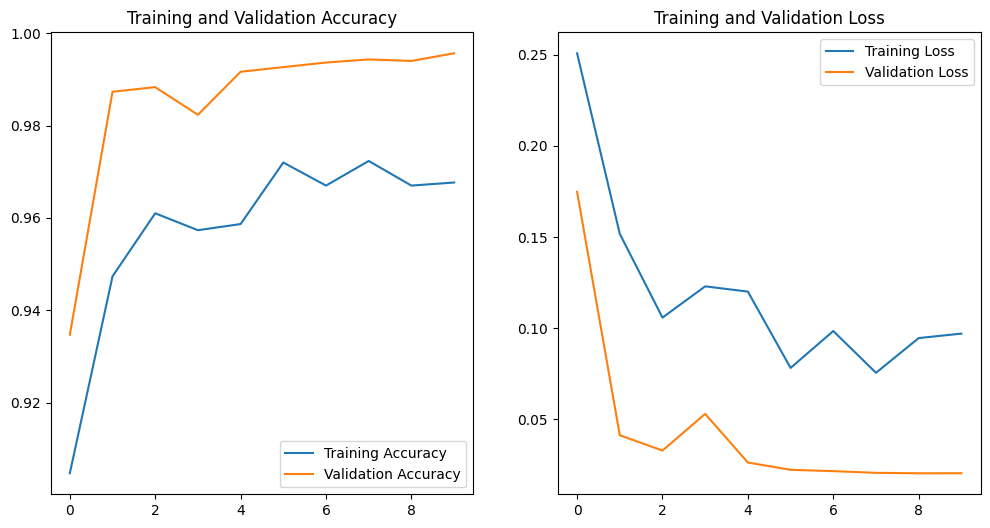

In [10]:
# Huấn luyện và kiểm tra mô hình
train_test_inception(model, train_loader, val_loader, epochs=10)